In [68]:
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import math
from moviepy.editor import VideoFileClip

In [ ]:
img = Image.open("gifs/4.gif")

arr = np.array(img)

blue_c = arr[259:279, 32:52, :]
Image.fromarray(blue_c).save("pink.png")

plt.imshow(arr[259:279, 32:52, :])

In [3]:
def getCoords(img, template, find_num, show=False):
    List = []
    w, h = template.shape[0], template.shape[1]

    showImg = img.copy()

    result = cv2.matchTemplate(img,template, cv2.TM_CCOEFF_NORMED)
    # get find_num best matches
    loc = np.where(result >= np.sort(result.flatten())[-find_num])
    

    for i in zip(*loc[::-1]):
        location = (i[0] + w, i[1] + h)
        List.append([i, location])

        cv2.rectangle(showImg, i, location, 255, 0)

    List = sorted(List, key=lambda x: x[0][1])

    if show:
        plt.imshow(showImg)
        plt.show()
    return List

In [73]:
gifs = os.listdir("gifs")

os.system("rm -rf processedImgs")
os.mkdir("processedImgs")

for gif in gifs:
    img = cv2.imread(f'gifs/{gif}',-1)
    blue_template = cv2.imread('blue.png',-1)
    pink_template = cv2.imread('pink.png',-1)

    img_w, img_h = img.shape[1], img.shape[0]

    blueCoord = getCoords(img, blue_template, 3, show=False)
    pinkCoord = getCoords(img, pink_template, 1, show=False)

    # find solution_idx
    solution_idx = 0
    for coord in blueCoord:
        if pinkCoord[0][0][1] > coord[0][1]:
            solution_idx += 1
        else:
            break

    # create subfolder
    os.mkdir(f"processedImgs/{gif.replace('.gif', '')}_{solution_idx}")

    allCoord = [
        [(0, 0), (0, 0)], 
        *blueCoord[:solution_idx], 
        *pinkCoord,
        *blueCoord[solution_idx:],
        [(img_h, img_h), (img_h, img_h)]
    ] # coords for lines

    for i in range(len(allCoord) - 1):
        # adjust coords
        lower_coord = max(0, allCoord[i][0][1])
        upper_coord = allCoord[i+1][0][1]

        if i == 0:
            while np.sum(img[upper_coord-2:upper_coord, :, 1]) != 0:
                upper_coord -= int(0.01 * img_h)

            img_block = img[lower_coord:upper_coord, :] # take whole slice

        else:
            while np.sum(img[lower_coord:lower_coord+2, allCoord[i][0][0]:, 1]) != 0:
                lower_coord -= int(0.01 * img_h)

            while np.sum(img[upper_coord-2:upper_coord, allCoord[i][0][0]:, 1]) != 0:
                upper_coord -= int(0.01 * img_h)

            img_block = img[lower_coord:upper_coord, allCoord[i][1][0]+2:img_w] # take slice from right of blue/pink template

        # crop image
        ret, thresh = cv2.threshold(img_block,20,255,cv2.THRESH_BINARY)
        white_pt_coords=np.argwhere(thresh)
        min_y = min(white_pt_coords[:,0])
        min_x = min(white_pt_coords[:,1])
        max_y = max(white_pt_coords[:,0])
        max_x = max(white_pt_coords[:,1])

        crop = img_block[
            max(0, min_y-2):min(max_y+2, img_block.shape[0]),
            max(0, min_x-2):min(max_x+2, img_block.shape[1])
        ]
        
        crop[:,:,0] = 0
        
        crop = Image.fromarray(crop).convert('LA')

        # manipulate solution image
        if i == solution_idx + 1:
            # erode
            crop = np.array(crop)
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
            crop = cv2.erode(crop, kernel, iterations=1)
           
            # interpolate
            x_p = [i for i in range(256)]
            y_p = [max(0, i - 35) for i in range(256)]
            # y_p = [max(0, i - 10) for i in range(120)] + [109 + (255 - 119) * (1 - math.exp(-0.006 * (i - 10))) for i in range(120, 180)] + [(i - 15) for i in range(180, 256)]

            alpha = crop[:,:,1]
            alpha = np.interp(alpha, x_p, y_p)
            crop[:,:,1] = alpha

            crop = Image.fromarray(crop, mode='LA')

        if i == 0:
            # dilate
            crop = np.array(crop)
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
            crop = cv2.dilate(crop, kernel, iterations=1)

            # interpolate
            x_p = [i for i in range(256)]
            y_p = [max(0, i - 10) for i in range(120)] + [109 + (255 - 119) * (1 - math.exp(-0.01 * i)) for i in range(120, 235)] + [i for i in range(235, 256)]

            alpha = crop[:,:,1]
            alpha = np.interp(alpha, x_p, y_p)
            crop[:,:,1] = alpha

            crop = Image.fromarray(crop, mode='LA')

        crop = ImageEnhance.Brightness(crop).enhance(0.4)

        # show image
        # plt.imshow(crop)
        # plt.show()

        if i == 0:
            crop.save(f"processedImgs/{gif.replace('.gif', '')}_{solution_idx}/q.png")
        else:
            crop.save(f"processedImgs/{gif.replace('.gif', '')}_{solution_idx}/a{i}.png")

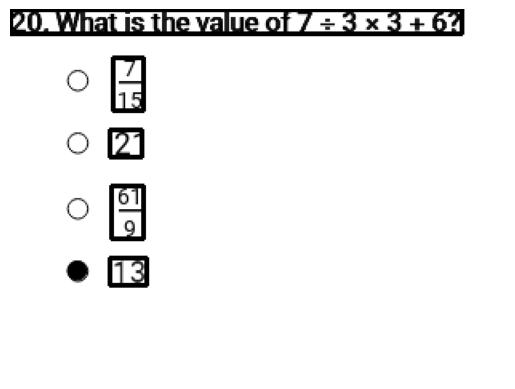

MoviePy - Building file out.gif with imageio.


In [72]:
img = cv2.imread(f'gifs/0.gif',-1)
blue_template = cv2.imread('blue.png',-1)
pink_template = cv2.imread('pink.png',-1)

img_w, img_h = img.shape[1], img.shape[0]

out = cv2.VideoWriter('out.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 2, (img_w, img_h), False)

blueCoord = getCoords(img, blue_template, 3, show=False)
pinkCoord = getCoords(img, pink_template, 1, show=False)

solution_idx = 0
for coord in blueCoord:
    if pinkCoord[0][0][1] > coord[0][1]:
        solution_idx += 1
    else:
        break

allCoord = [
    [(0, 0), (0, 0)], 
    *blueCoord[:solution_idx], 
    *pinkCoord,
    *blueCoord[solution_idx:],
    [(img_h, img_h), (img_h, img_h)]
] # coords for lines

img = Image.fromarray(img)
img = img.convert('LA')
img = np.array(img)
img[:,:,0] = 0

showImg = img.copy()
out.write(255 - showImg[:, :, 1].astype(np.uint8))

for i in range(len(allCoord) - 1):
        # adjust coords
        lower_coord = max(0, allCoord[i][0][1])
        upper_coord = allCoord[i+1][0][1]

        liveShowImg = showImg.copy()
        cv2.line(liveShowImg, (0, lower_coord), (img_w, lower_coord), (0, 255), 1)
        out.write(255 - liveShowImg[:, :, 1].astype(np.uint8))

        if i == 0:
            while np.sum(img[upper_coord-2:upper_coord, :, 1]) != 0:
                upper_coord -= int(0.01 * img_h)
                liveShowImg = showImg.copy()
                cv2.line(liveShowImg, (0, upper_coord), (img_w, upper_coord), (0, 255), 1)
                out.write(255 - liveShowImg[:, :, 1].astype(np.uint8))

            img_block = img[lower_coord:upper_coord, :] # take whole slice
            liveShowImg = showImg.copy()
            cv2.rectangle(liveShowImg, (0, lower_coord), (img_w, upper_coord), (0, 255), 1)
            out.write(255 - liveShowImg[:, :, 1].astype(np.uint8))

        else:
            while np.sum(img[lower_coord:lower_coord+2, allCoord[i][0][0]:, 1]) != 0:
                lower_coord -= int(0.01 * img_h)
                liveShowImg = showImg.copy()
                cv2.line(liveShowImg, (0, lower_coord), (img_w, lower_coord), (0, 255), 1)
                out.write(255 - liveShowImg[:, :, 1].astype(np.uint8))

            while np.sum(img[upper_coord-2:upper_coord, allCoord[i][0][0]:, 1]) != 0:
                upper_coord -= int(0.01 * img_h)
                liveShowImg = showImg.copy()
                cv2.line(liveShowImg, (0, upper_coord), (img_w, upper_coord), (0, 255), 1)
                out.write(255 - liveShowImg[:, :, 1].astype(np.uint8))

            img_block = img[lower_coord:upper_coord, allCoord[i][1][0]+2:img_w] # take slice from right of blue/pink template
            liveShowImg = showImg.copy()
            cv2.rectangle(liveShowImg, (allCoord[i][1][0]+2, lower_coord), (img_w, upper_coord), (0, 255), 1)
            out.write(255 - liveShowImg[:, :, 1].astype(np.uint8))

        # crop image
        ret, thresh = cv2.threshold(img_block,20,255,cv2.THRESH_BINARY)
        white_pt_coords=np.argwhere(thresh)
        min_y = min(white_pt_coords[:,0])
        min_x = min(white_pt_coords[:,1])
        max_y = max(white_pt_coords[:,0])
        max_x = max(white_pt_coords[:,1])

        crop = img_block[
            max(0, min_y-2):min(max_y+2, img_block.shape[0]),
            max(0, min_x-2):min(max_x+2, img_block.shape[1])
        ]

        # manipulate solution image
        if i == solution_idx + 1:
            # erode
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
            crop = cv2.erode(crop, kernel, iterations=1)
           
            # interpolate
            x_p = [i for i in range(256)]
            y_p = [max(0, i - 35) for i in range(256)]
            # y_p = [max(0, i - 10) for i in range(120)] + [109 + (255 - 119) * (1 - math.exp(-0.006 * (i - 10))) for i in range(120, 180)] + [(i - 15) for i in range(180, 256)]

            alpha = crop[:,:,1]
            alpha = np.interp(alpha, x_p, y_p)
            crop[:,:,1] = alpha

            showImg[lower_coord + max(0, min_y-2):lower_coord + min(max_y+2, img_block.shape[0]), allCoord[i][1][0] + max(0, min_x-2):allCoord[i][1][0] + min(max_x+2, img_block.shape[1])] = crop
            out.write(255 - showImg[:, :, 1].astype(np.uint8))

            cv2.rectangle(showImg, (allCoord[i][1][0] + max(0, min_x-2), lower_coord + max(0, min_y-2)), (allCoord[i][1][0] + min(max_x+2, img_block.shape[1]), lower_coord + min(max_y+2, img_block.shape[0])), (0, 255), 2)
            out.write(255 - showImg[:, :, 1].astype(np.uint8))
            
        if i == 0:
            # dilate
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
            crop = cv2.dilate(crop, kernel, iterations=1)

            # interpolate
            x_p = [i for i in range(256)]
            y_p = [max(0, i - 10) for i in range(120)] + [109 + (255 - 119) * (1 - math.exp(-0.01 * i)) for i in range(120, 235)] + [i for i in range(235, 256)]

            alpha = crop[:,:,1]
            alpha = np.interp(alpha, x_p, y_p)
            crop[:,:,1] = alpha

            showImg[lower_coord + max(0, min_y-2):lower_coord + min(max_y+2, img_block.shape[0]), max(0, min_x-2):min(max_x+2, img_block.shape[1])] = crop
            out.write(255 - showImg[:, :, 1].astype(np.uint8))

            cv2.rectangle(showImg, (max(0, min_x-2), lower_coord + max(0, min_y-2)), (min(max_x+2, img_block.shape[1]), lower_coord + min(max_y+2, img_block.shape[0])), (0, 255), 2)
            out.write(255 - showImg[:, :, 1].astype(np.uint8))

        else:
            cv2.rectangle(showImg, (allCoord[i][1][0] + max(0, min_x-2), lower_coord + max(0, min_y-2)), (allCoord[i][1][0] + min(max_x+2, img_block.shape[1]), lower_coord + min(max_y+2, img_block.shape[0])), (0, 255), 2)
            out.write(255 - showImg[:, :, 1].astype(np.uint8))

        crop = Image.fromarray(crop).convert('LA')
        crop = ImageEnhance.Brightness(crop).enhance(0.4)

for i in range(5):
    out.write(255 - showImg[:, :, 1].astype(np.uint8))

showImg = Image.fromarray(showImg)
# plt imshow without axis
plt.axis('off')
plt.imshow(showImg, cmap='gray')
plt.show()

out.release()

videoClip = VideoFileClip("out.mp4")
videoClip.write_gif("out.gif", fps=2)